## Etape 1 : Scraping des résultats depuis bases.athle

Objectifs :
+ créer un pipeline pour récupérer les données d'une compétition d'athlétisme (course sur route, trail, cross, ...)
+ retourner ces données sous la forme d'une table relationnelle
+ par la suite, exploiter cette table pour créer des statistiques et visualisations sur les compétitions

Format d'une URL de bases.athle :
+ ? avant la requête
+ & pour ajouter des paramètres à la recherche 

bases.athle.fr/asp.net/liste.aspx**?frmbase=resultats**&**frmmode=1**&**frmespace=0**&**frmcompetition=**274211

Liste des paramètres pour une recherche par athlète :
+ frmsaison
+ frmclub
+ frmnom
+ frmprenom
+ frmsexe
+ frmlicence
+ frmdepartement
+ frmligue
+ frmcomprch


### Installation de la libraire lxml

In [1]:
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 17.9 MB/s eta 0:00:00a 0:00:01


### Import des librairies requises

In [2]:
import lxml
import urllib
import bs4
import pandas as pd
import numpy as np
import re
from urllib import request

Les pages de résultats de base.athle possèdent toutes la même forme, mais les en-têtes et les informations sur les différentes courses diffèrent en termes de contenu.

Par exemple, il peut y avoir les classements des équipes dans l'en-tête, ce qui rend le scraping complexe, puisqu'il faut différencier ces résultats des résultats individuels. Des informations supplémentaires sur les compétitions (société de chronométrage, etc.) peuvent être présentes dans l'en-tête également.

La cellule suivante récupère uniquement la table des résultats individuels en supprimant les cases contenant :
+ des résultats de groupes "groups"
+ l'en-tête principale "mainheaders"
+ l'en-tête de la table "barButtons"
+ le sous-titre de la table "subheaders"

In [57]:
nb_pages=80
url="https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=254295&frmposition="

In [58]:
L=[]
for i in range(nb_pages):
    url=url+str(i)
    request_text = request.urlopen(url).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    for i in page.find_all('tr'):
        if "groups" not in str(i) and "mainheaders" not in str(i) and "barButtons" not in str(i) and "subheaderscom" not in str(i):
            L.append(i)

### Dictionnaires utiles

#### Catégories de performance et cotation d'après table FFA

In [59]:
#bareme et table de cotation
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=125

perf = {'IA': 40, 'IB': 35, #international
        'N1': 30, 'N2': 28, 'N3': 26, 'N4': 24, #national
        'IR1': 21, 'IR2': 20, 'IR3': 19, 'IR4': 18, #inter-regional
        'R1': 15, 'R2': 14, 'R3': 13, 'R4': 12, 'R5': 11, 'R6': 10, #regional
        'D1': 8, 'D2': 7, 'D3': 6, 'D4': 5, 'D5': 4, 'D6': 3, 'D7': 2} #departemental

#### Catégories d'âge d'après la réglementation FFA

In [60]:
#categories d'âge en 2023
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=25

cat = {'M10': 'Masters 10', 'M9': 'Masters 9', 'M8': 'Masters 8', 'M7': 'Masters 7', 'M6': 'Masters 6',
       'M5': 'Masters 5', 'M4': 'Masters 4', 'M3': 'Masters 3', 'M2': 'Masters 2', 'M1': 'Masters 1', 'M0': 'Masters 0',
       'SE': 'Seniors',
       'ES': 'Espoirs',
       'JU': 'Juniors',
       'CA': 'Cadet.te.s',
       'MI': 'Minimes',
       'BE': 'Benjamin.e.s',
       'PO': 'Poussins',
       'EA': 'École d\'Athlétisme',
       'BB': 'Baby Athlé'}

In [61]:
#ajout de féminin (F) et masculin (M) aux categories

categoriesF=list(cat.keys())

#ajout des catégories féminines
for i in range(len(categoriesF)):
    categoriesF[i]+='F'
categoriesM=list(cat.keys())

#ajout des catégories masculines
for i in range(len(categoriesM)):
    categoriesM[i]+='M'
    
categories=categoriesF+categoriesM

## Date, nom, lieu, ligue, label et département de la compétition

In [62]:
header = page.find('div', {'class' : "mainheaders"})
header=str(header)
print(header)

<div class="mainheaders">25/09/22 - Paris-Versailles<br/><span style="font-size:13px">VERSAILLES - I-F - 078</span></div>


#### Nom de la compétition

In [63]:
re_nom = re.compile("(?<=\- )(.*?)(?=\<)")
text = re_nom.findall(header)
nom = text[0]
sous_titre = text[1]
print(nom)

Paris-Versailles


#### Lieu de la compétition

In [64]:
re_lieu = re.compile("(?<=\>)(\D*?)(?=\ -)")
lieu = re_lieu.findall(header)[0]
print(lieu)

VERSAILLES


#### Date de la compétition

In [65]:
re_date = re.compile("[0-9]{2}/[0-9]{2}/[0-9]{2}")
date = re_date.findall(header)[0]
print(date)

25/09/22


#### Département de la compétition

In [66]:
re_dept = re.compile("[0-9]{3}")
dept = re_dept.findall(sous_titre)[0]
print(dept)

078


#### Label de la compétition (en cours)

In [67]:
re_label = re.compile("(?<=Label ).*(?<!')")
try:
    label = re_label.findall(sous_titre)[0]
    print(label)
except IndexError:
    print("Pas de label pour cette compétition")

Pas de label pour cette compétition


#### Données de la compétition sous forme de dictionnaire

In [68]:
compet= {'nom': nom,
      'lieu': lieu,
      'date': date,
      'dept': dept,
      'label': label}

In [69]:
compet

{'nom': 'Paris-Versailles',
 'lieu': 'VERSAILLES',
 'date': '25/09/22',
 'dept': '078',
 'label': 'National'}

## Athlètes et chronos de la compétition

### Athlètes

In [70]:
re_athlete = re.compile("[A-Z]{2,} ?-?[A-Z]* ?-?[A-Z]* ?-?[A-Z]*[A-Z]{1}[a-z]+ ?-?[A-Z]?[a-z]*")

In [71]:
athletes=[]
for i in L:
    athletes.append(re_athlete.findall(str(i)))
athletes=[x for x in athletes if x!=[]]
athletes[:10]

[['DOURLENS Justin'],
 ['MICHEL Arnaud'],
 ['KERRAND Louis-Marie'],
 ['LASTENNET Glenn'],
 ['DESCOT Alexandre'],
 ['SANTOS Luis'],
 ['VOGT Romain'],
 ['BIROLLEAU Alexandre'],
 ['LIGUORI Sacha'],
 ['DALMASSO Nicolas']]

### Chronos de la compétition

In [72]:
re_temps = re.compile("<b>(?=\d).*(?=<\/b>)")

In [73]:
temps=[]
for i in L:
    temps.append(re_temps.findall(str(i)))
temps=[x for x in temps if x!=[]]
for i in range(len(temps)):
    temps[i]=temps[i][0].replace("<b>","")
    temps[i]=pd.to_datetime(temps[i], format='%Hh%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%S\'\'', errors='ignore')
temps[:5]

[Timestamp('1900-01-01 00:53:01'),
 Timestamp('1900-01-01 00:53:05'),
 Timestamp('1900-01-01 00:53:11'),
 Timestamp('1900-01-01 00:53:36'),
 Timestamp('1900-01-01 00:53:51')]

### Ligue des athlètes

In [74]:
re_ligue = re.compile("[A-Z]{3,}(?=<)|[A-Z]-[A-Z](?=<)")

In [75]:
ligue=[]
for i in L:
    match = re_ligue.search(str(i))
    if (match==None) or (match.group() in categories):
        ligue.append('0')
    else:
        ligue.append(match.group())
ligue[:10]

['0', '0', '0', 'I-F', 'H-F', 'I-F', 'I-F', '0', '0', 'I-F']

### Cotations des performances

In [76]:
re_perf = re.compile("[A-Z]{1}[1-8](?=<)|I[A,B](?=<)")

In [77]:
perfs=[]
for i in L:
    match= str(re_perf.findall(str(i))).replace('[','').replace(']','').replace('\'','')
    if match in list(perf.keys()):
        perfs.append(match)
    else:
        perfs.append('')
perfs[:10]

['', '', '', '', '', '', '', '', '', '']

### Catégories des athlètes

In [78]:
re_cat = re.compile("[A-Z]{3}(?=<)|[A-Z]{1}\d[A-Z]{1}")

In [79]:
categorie=[]
for i in L:
    match = re_cat.search(str(i))
    if (match==None):
        categorie.append(None)
    else:
        match = re_cat.findall(str(i))
        if len(match)>1 and (match[1] in categories):
            categorie.append(match[1])
        else:
            if (match[0] in categories):
                categorie.append(match[0])
categorie[:10]

[None, None, None, 'SEM', 'M0M', 'SEM', 'M0M', 'M1M', 'ESM', 'M0M']

### Années de naissance

In [80]:
re_annee = re.compile("\/[0-9]{2}<")

In [81]:
annee=[]
for i in L:
    match = re_annee.search(str(i))
    if (match==None) or (match.group() in categories):
        annee.append('0')
    else:
        year = int(str(match.group()).replace('/','').replace('<',''))
        if year <=20:
            annee.append(year+2000)
        else:
            annee.append(year+1900)

In [82]:
annee[:10]

['0', '0', '0', 1994, 1987, 1990, 1985, 1982, 2001, 1987]

### Clubs des athlètes (en cours)

In [83]:
re_club = re.compile("[A-Z][a-z]+ *-*[A-Z][a-z]+ *-*[A-Z]*[a-z] *-*[A-Z]*[a-z]*(?=<)")

In [84]:
clubs=[]
for i in L:
    match = re_club.findall(str(i))
clubs[:10]

[]

### Suppression des lignes ne contenant pas les enregistrements des athlètes

In [85]:
len(athletes), len(perfs), len(ligue), len(clubs), len(annee), len(categorie), len(temps)

(17536, 17827, 17827, 0, 17827, 17827, 16750)

In [86]:
#identification du début de la table de résultats individuels à l'aide de la liste des catégories 

i = 0
while categorie[i]==None:
    i+=1
debut=i
print(debut)

3


In [87]:
liste=[]
for i in range(len(athletes)):
    ligne=[]
    ligne.append(athletes[i][0])
    ligne.append(ligue[i+debut])
    #ligne.append(str(clubs[i+debut]))
    ligne.append(temps[i])
    ligne.append(perfs[i+debut])
    ligne.append(annee[i+debut])
    ligne.append(categorie[i+debut])
    liste.append(ligne)

IndexError: list index out of range

In [88]:
data=pd.DataFrame(liste, columns=["Athlète", "Ligue", "Chrono", "Performance", "Naissance", "Catégorie"])

In [89]:
data['hours']=data['Chrono'].dt.hour
data['minutes']=data['Chrono'].dt.minute
data['seconds']=data['Chrono'].dt.second

In [90]:
data['time_delta']=data['Chrono']-pd.to_datetime("'1900-01-01")
data=data.sort_values('time_delta')

In [91]:
data=data.reset_index(drop=True)

In [92]:
data['time_gap']=data["Chrono"]-data['Chrono'][0]
data['duration']=data['time_delta'].dt.total_seconds()

#data['Nom']=data['Athlète'].str.split(n = 0, expand = False).str[0]
#data['Prénom']=data['Athlète'].str.split(n = 0, expand = False).str[1]

data=data.drop("Chrono", axis=1)
data.head(10)

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
0,DOURLENS Justin,I-F,,1994,SEM,0,53,1,0 days 00:53:01,0 days,3181.0
1,YAO Zejun,0,,1994,SEM,0,53,1,0 days 00:53:01,0 days,3181.0
2,COLLET Benoit,I-F,,1973,M3M,0,53,1,0 days 00:53:01,0 days,3181.0
3,CANDAU Tristan,0,,1983,M1M,0,53,1,0 days 00:53:01,0 days,3181.0
4,METAIS Simon,I-F,,1997,SEF,0,53,1,0 days 00:53:01,0 days,3181.0
5,DURAND Pierre,I-F,,1972,M3M,0,53,1,0 days 00:53:01,0 days,3181.0
6,QUEMENER Yann,0,,1993,SEM,0,53,1,0 days 00:53:01,0 days,3181.0
7,PERDEREAU Cedric,0,,1993,SEM,0,53,1,0 days 00:53:01,0 days,3181.0
8,SCHNEIDER Rafael,0,,1978,M2M,0,53,1,0 days 00:53:01,0 days,3181.0
9,ATTALA Maurice,I-F,,1972,M3M,0,53,1,0 days 00:53:01,0 days,3181.0


In [93]:
data.describe()

,hours,minutes,seconds,time_delta,time_gap,duration
count,16750.000000,16750.000000,16750.000000,16750,16750,16750.000000
mean,0.743881,16.832418,31.435343,0 days 01:01:59.350567164,0 days 00:08:58.350567164,3719.350567
std,0.436502,23.219227,17.902299,0 days 00:03:44.655341926,0 days 00:03:44.655341926,224.655342
min,0.000000,0.000000,0.000000,0 days 00:53:01,0 days 00:00:00,3181.000000
25%,0.000000,2.000000,15.000000,0 days 00:59:58,0 days 00:06:57,3598.000000
50%,1.000000,4.000000,32.000000,0 days 01:02:33,0 days 00:09:32,3753.000000
75%,1.000000,53.000000,48.000000,0 days 01:04:54,0 days 00:11:53,3894.000000
max,1.000000,59.000000,59.000000,0 days 01:13:37,0 days 00:20:36,4417.000000


### Premier exemple de visualisation : distribution des chronos

<AxesSubplot: ylabel='Density'>

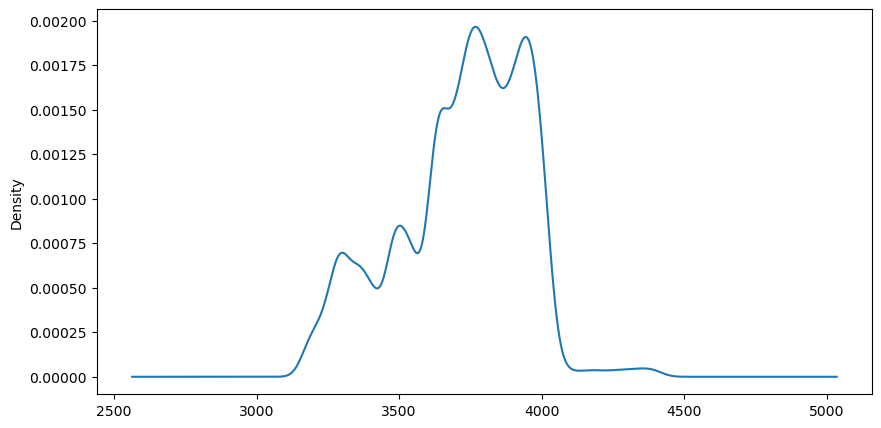

In [94]:
data["duration"].plot(kind='kde', figsize=(10,5))

### Deuxième exemple de visualisation : écart avec le premier

<AxesSubplot: >

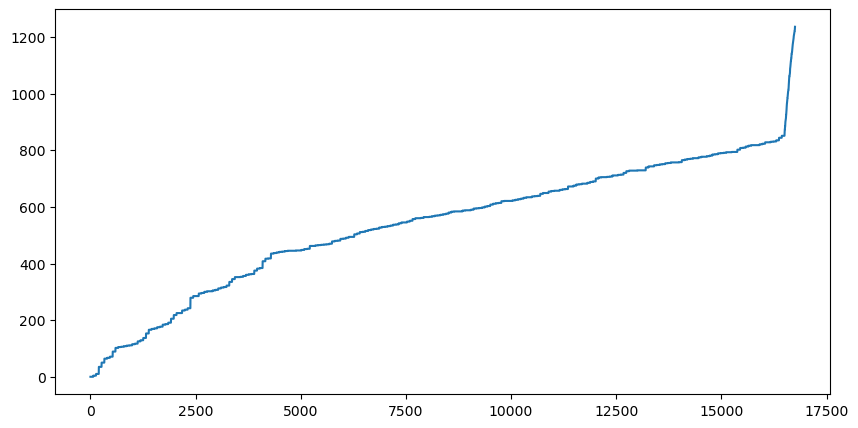

In [95]:
data["time_gap"].dt.total_seconds().plot(figsize=(10,5))

### Troisième exemple de visualisation : histogramme des performances (labels FFA)

<AxesSubplot: >

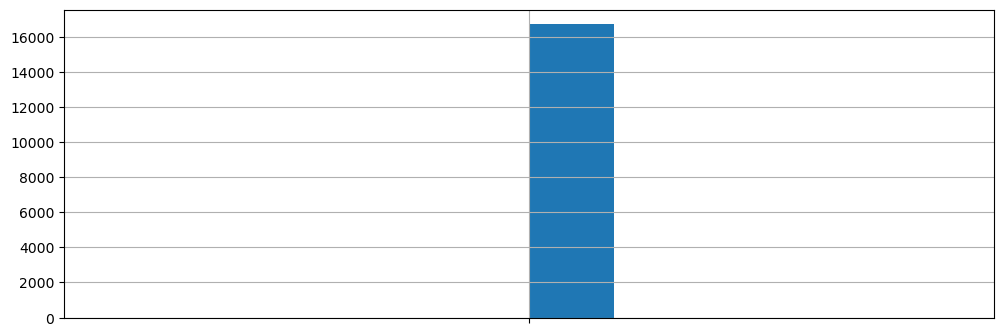

In [96]:
data["Performance"].hist(figsize=(12,4))

<AxesSubplot: >

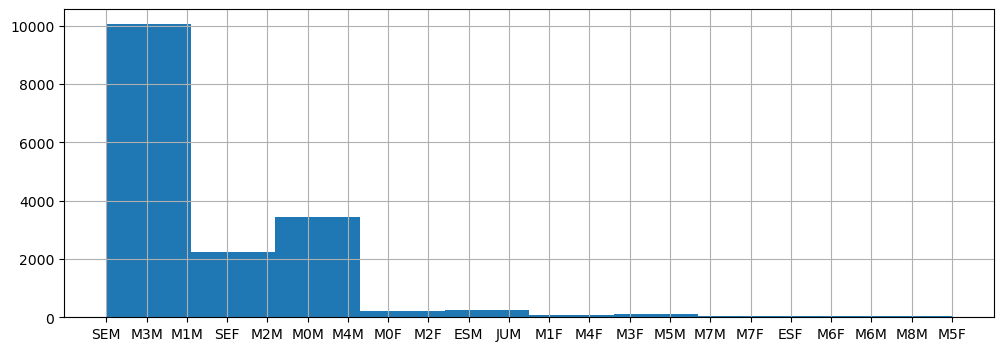

In [97]:
data["Catégorie"].hist(figsize=(12,4))

### Exemple output en csv

In [98]:
#data=data.drop("Club", axis=1)
data.to_csv("Paris-Versailles_TC.csv", index=False)